In [17]:
import numpy as np
import matplotlib.pylab as plt
from copy import copy as cp
import matplotlib.patches as patches

In [18]:
%matplotlib notebook

In [19]:
# Aesthetics ... fills in the box with an arbitrary constant value
def fillin(un,ixbox,iybox,overrideflag=0,overrideval=0):
    border = cp(un[ixbox.start-1,iybox.start])
    if(overrideflag == 1):
        border = overrideval
    un[ixbox,iybox] = border
    return un

In [20]:
# The differential equation solver
def propagate(u0_orig,ixbox,iybox,gneumanneffx,gneumanneffy,Dxeff,Dyeff):
    
    # Diffusion
    u0 = cp(u0_orig)
    un = np.zeros(np.shape(u0))
    un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
    (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])*Dxeff + \
    (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])*Dyeff )

    # Dirichlet outer boundary
    un[[0,-1],:]=udirichlet
    un[:,[0,-1]]=udirichlet
        
    # Pull out the stop and start indices
    ixmin = ixbox.start
    ixmax = ixbox.stop-1
    iymin = iybox.start
    iymax = iybox.stop-1

    # Inner boundary: diffusion and Neumann
    un[ixmin-1,iybox] = u0[ixmin-1,iybox] +(u0[ixmin-2,iybox] - u0[ixmin-1,iybox])*Dxeff -gneumanneffx
    un[ixmax+1,iybox] = u0[ixmax+1,iybox] +(u0[ixmax+2,iybox] - u0[ixmax+1,iybox])*Dxeff -gneumanneffx

    un[ixbox,iymin-1] = u0[ixbox,iymin-1] +(u0[ixbox,iymin-2] - u0[ixbox,iymin-1])*Dyeff -gneumanneffy
    un[ixbox,iymax+1] = u0[ixbox,iymax+1] +(u0[ixbox,iymax+2] - u0[ixbox,iymax+1])*Dyeff -gneumanneffy
    
    # Also zero-out inside the box (this is just aesthetic)
    un = fillin(un,ixbox, iybox, overrideflag=1, overrideval=0)
    
    return un

In [30]:
# Simulation space dimensions, etc. edited by Clarke 02.21.2022
nx = 253
ny = 253
xmax,ymax = 1000.0, 1000.0 #micrometers

x = np.linspace(0,xmax,nx); dx = x[1]-x[0]; print('dx', dx)
y = np.linspace(0,ymax,ny); dy = y[1]-y[0]; print('dy',dy)
dx2 = dx**2
dy2 = dy**2
nxmid = int(nx/2); # print('nxmid =', nxmid); # print('x(nxmid) =',x[nxmid])
nymid = int(ny/2)
x = x-x[nxmid]
y = y-y[nymid]

# Compute diffusion coefficient at this temperature
D_SI_300 = 24.0e-6 # m^2/s
D_300 = D_SI_300 * 1e6  # um^2/us
print('D of water vapor through air at 300 K, 1 atm = ', D_300)
Temp = 240.0
Pressure = .2 # Not sure what the units are here
Pressure = .1 # Not sure what the units are here
acoef = 2.072
D = D_300*(Temp/300)**acoef/(Pressure/1.0)
print('D of water vapor through air at ',Temp,' K, ',Pressure,' atm = ', D)

dt = (dx2+dy2)/D/10; print('dt = ', dt)
Dxeff = D*dt/dx2
Dyeff = D*dt/dy2

# Here's the part that involved some guesswork ... getting the Neumann coefficient
gneumann_nu_kin = D/(nx-1); print('gneumann_kin', gneumann_nu_kin)
nu_kin_ml = 0.113; print('nu_kin_ml = ', nu_kin_ml)
# nu_kin_ml = 0.113*2 # This results in c_r that's identical (because it divides out)
kfactor = gneumann_nu_kin/nu_kin_ml; # print('kfactor', kfactor)
alphasigma = .374; print('alpha*sigma', alphasigma)
# alphasigma = .5; print('alpha*sigma', alphasigma) # This results in c_r that's identical to 0.372 (but sigmaI_corner is bigger)
gneumann = kfactor * nu_kin_ml; print('gneumann', gneumann)
gneumanneffx = gneumann*dt/dx**2; # print('gneumann effective, x', gneumanneffx)
gneumanneffy = gneumann*dt/dy**2; # print('gneumann effective, y', gneumanneffy)
gneumanneffx_without_dt = gneumanneffx/dt; print('gneumanneffx_without_dt = ', gneumanneffx_without_dt)
gneumanneffx_without_dt = D/(xmax*dx); print('gneumanneffx_without_dt = ', gneumanneffx_without_dt)

# This is the far-field boundary
udirichlet = alphasigma

dx 3.9682539682539684
dy 3.9682539682539684
D of water vapor through air at 300 K, 1 atm =  24.0
D of water vapor through air at  240.0  K,  0.1  atm =  151.15192925969708
dt =  0.020836041767628478
gneumann_kin 0.599809243094036
nu_kin_ml =  0.113
alpha*sigma 0.374
gneumann 0.599809243094036
gneumanneffx_without_dt =  0.03809028617344367
gneumanneffx_without_dt =  0.03809028617344366


In [22]:
# # This restarts the array accumulation
Lx_list = np.array([]); c_rx_list = np.array([]); sigmamx_list = np.array([])
Ly_list = np.array([]); c_ry_list = np.array([]); sigmamy_list = np.array([])

# Looping
Ldesired_list = np.arange(30,110,10)
# Ldesired_list = np.arange(78,79,1)
aspect_ratio = 1
for Ldesired in Ldesired_list:
    
    # Define the box inside
    Ldesiredx = Ldesired # Doesn't always work out to this because the grid is discretized
    boxradx = int(Ldesiredx/dx)
    Lx = boxradx*dx; print('   Lx =', Lx)

    Ldesiredy = Ldesiredx*aspect_ratio
    boxrady = int(Ldesiredy/dy)
    Ly = boxrady*dy; print('   Ly =', Ly)

    ixboxmin = nxmid-boxradx
    ixboxmax = nxmid+boxradx
    iyboxmin = nymid-boxrady
    iyboxmax = nymid+boxrady

    # Setting up to slice through the volume
    ixbox = slice(ixboxmin,ixboxmax); print(ixbox)
    iybox = slice(iyboxmin,iyboxmax); print(iybox)

    # Initialize u0 and un as ones/zeros matrices 
    u0 = np.ones([nx, ny])*udirichlet # old u values
    u0 = fillin(u0, ixbox, iybox)

    # Initialize the state of the vapor field
    un = cp(u0)

    # Propagate forward a bunch of times
    ntimes = 30000
    for i in range(ntimes):
        un = propagate(un,ixbox,iybox,gneumanneffx,gneumanneffy,Dxeff,Dyeff)

    # Now a slice just across one of the box surfaces ( in the x dimension)
    uslicex = un[ixbox,nymid+boxrady]
    c_rx = (max(uslicex)-min(uslicex))*100
    print('c_r (x-direction) =', c_rx, '%')

    # Now a slice just across one of the box surfaces ( in the Y dimension)
    uslicey = un[nxmid+boxradx, iybox]
    c_ry = (max(uslicey)-min(uslicey))*100
    print('c_r (y-direction) =', c_ry, '%')

    # Accumulate
    Lx_list = np.append(Lx_list,Lx); c_rx_list = np.append(c_rx_list,c_rx); print(Lx_list,c_rx_list)
    Ly_list = np.append(Ly_list,Ly); c_ry_list = np.append(c_ry_list,c_ry); print(Ly_list,c_ry_list)
    sigmamx_list = np.append(sigmamx_list,uslicex[0])
    sigmamy_list = np.append(sigmamy_list,uslicey[0])
    
    # Reporting
    print('Done with Ldesired = ', Ldesired)
    print(' ')


   Lx = 27.77777777777778
   Ly = 27.77777777777778
slice(119, 133, None)
slice(119, 133, None)
c_r (x-direction) = 0.5618205201815996 %
c_r (y-direction) = 0.5618205201815996 %
[27.77777778] [0.56182052]
[27.77777778] [0.56182052]
Done with Ldesired =  30
 
   Lx = 39.682539682539684
   Ly = 39.682539682539684
slice(116, 136, None)
slice(116, 136, None)
c_r (x-direction) = 0.8745712086753538 %
c_r (y-direction) = 0.8745712086753538 %
[27.77777778 39.68253968] [0.56182052 0.87457121]
[27.77777778 39.68253968] [0.56182052 0.87457121]
Done with Ldesired =  40
 
   Lx = 47.61904761904762
   Ly = 47.61904761904762
slice(114, 138, None)
slice(114, 138, None)
c_r (x-direction) = 1.0853087570356217 %
c_r (y-direction) = 1.0853087570356217 %
[27.77777778 39.68253968 47.61904762] [0.56182052 0.87457121 1.08530876]
[27.77777778 39.68253968 47.61904762] [0.56182052 0.87457121 1.08530876]
Done with Ldesired =  50
 
   Lx = 59.523809523809526
   Ly = 59.523809523809526
slice(111, 141, None)
slice(1

<IPython.core.display.Javascript object>


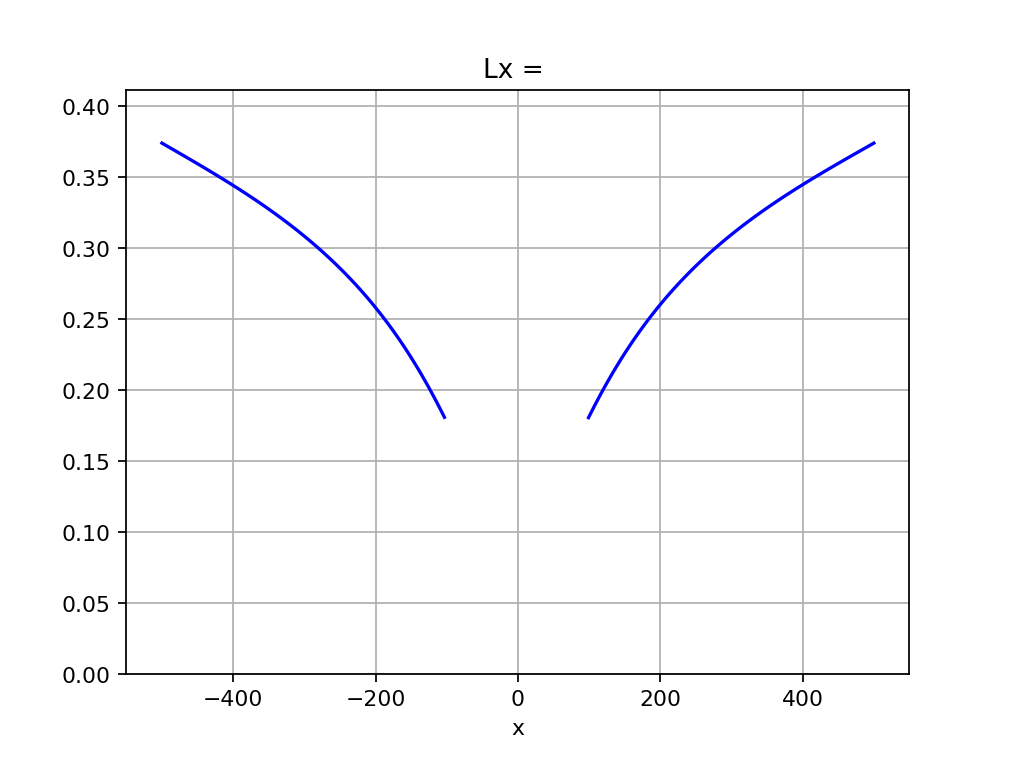

<IPython.core.display.Javascript object>


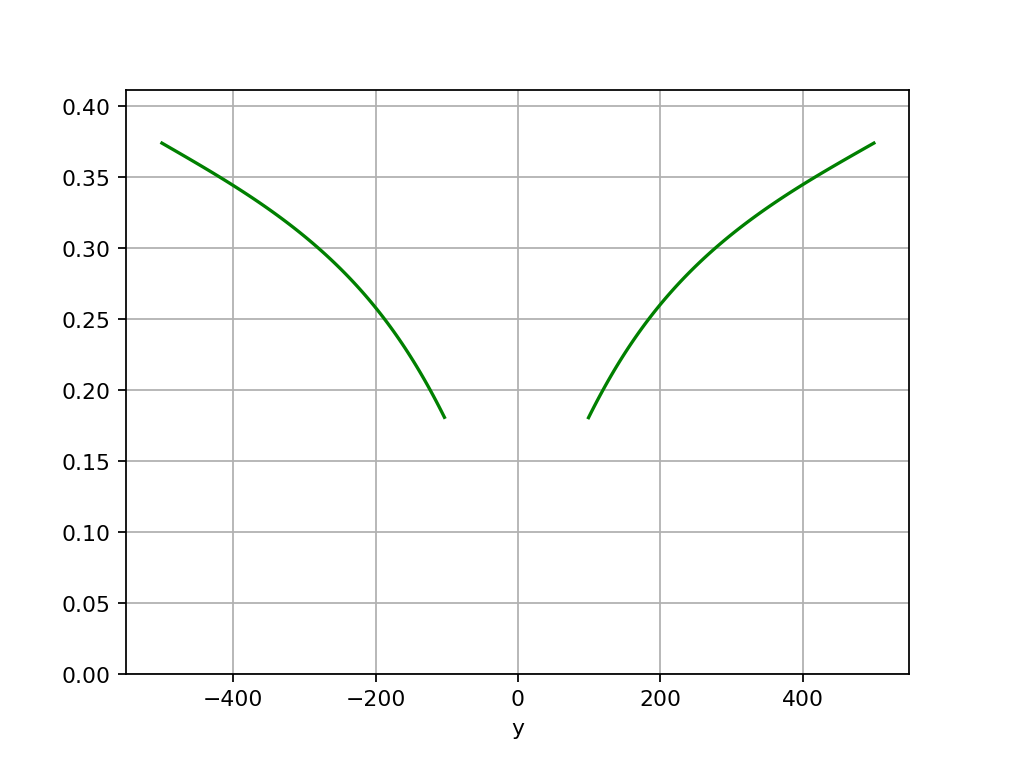

<IPython.core.display.Javascript object>


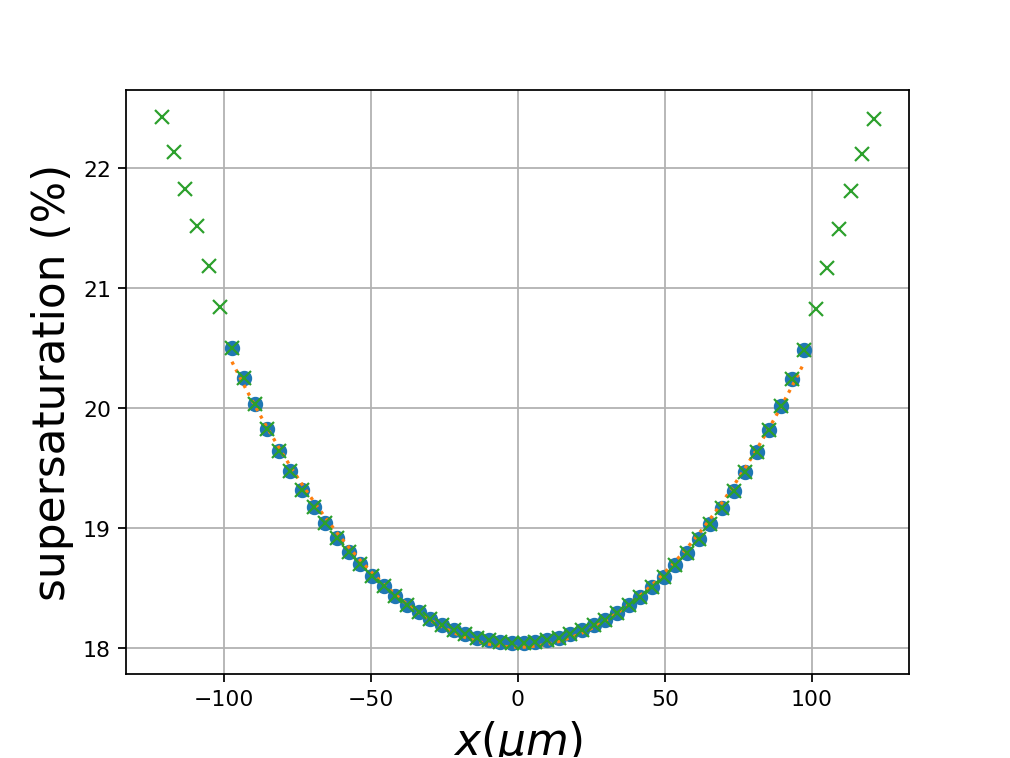

<IPython.core.display.Javascript object>


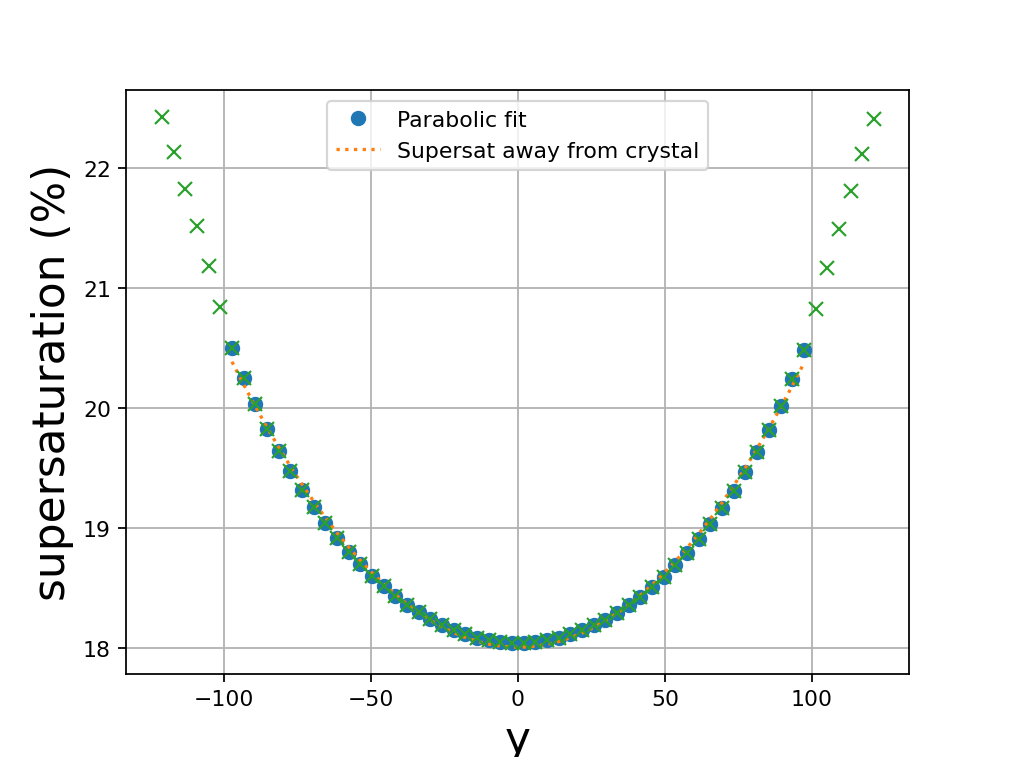

<IPython.core.display.Javascript object>


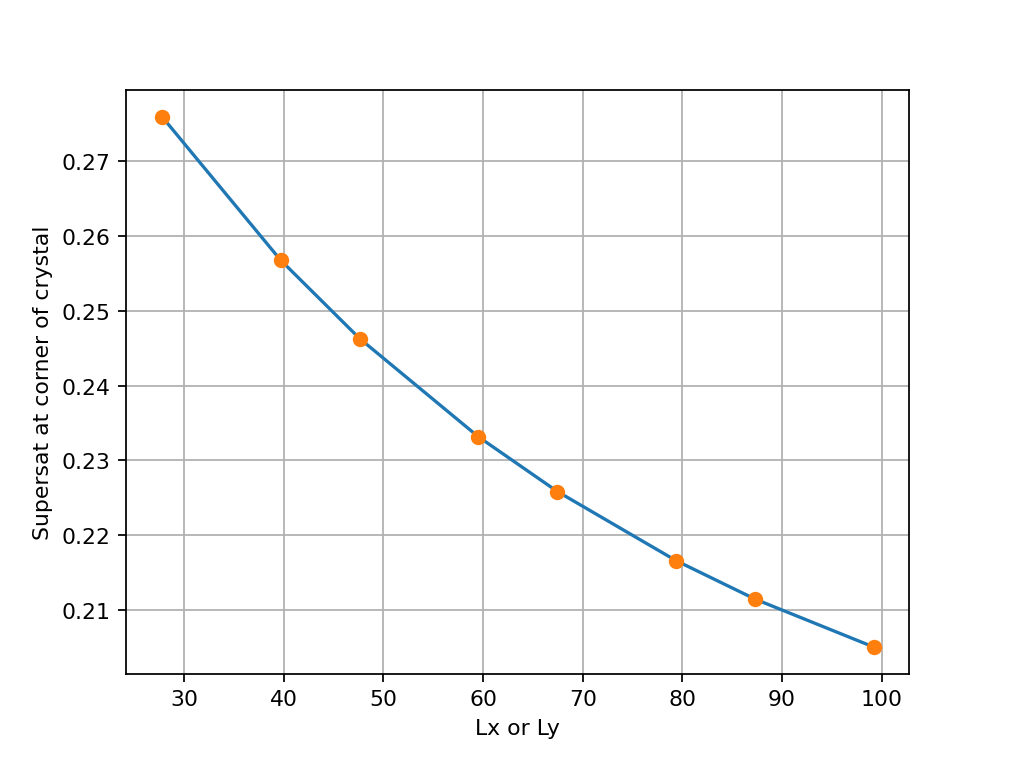

<IPython.core.display.Javascript object>


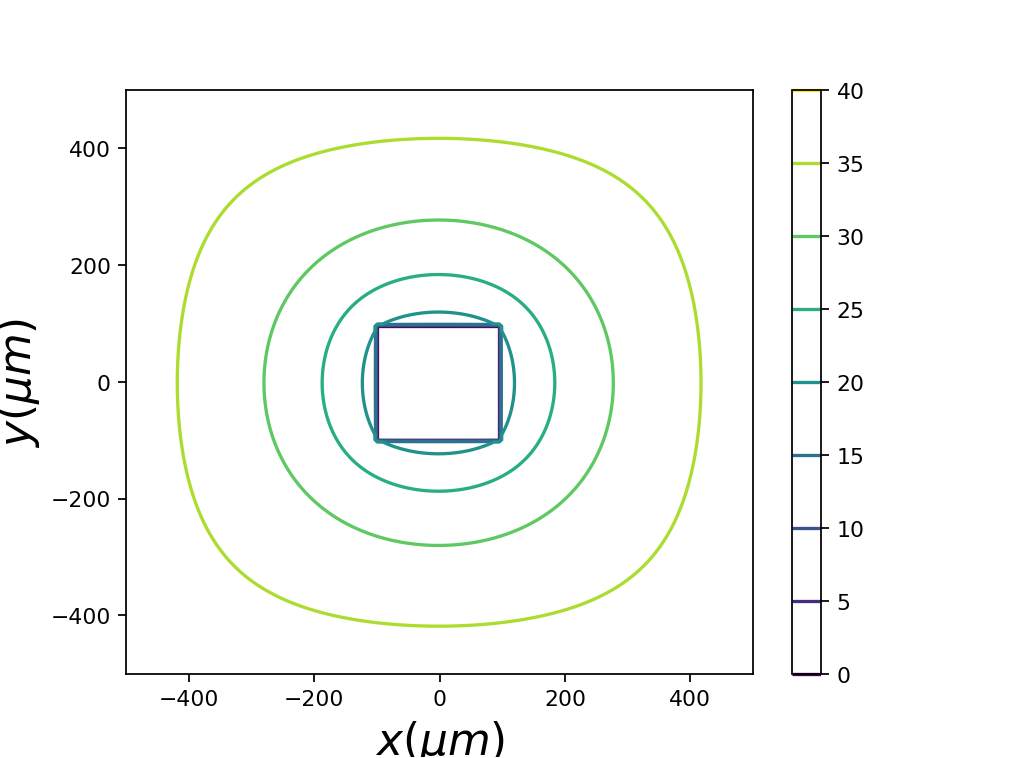

<IPython.core.display.Javascript object>


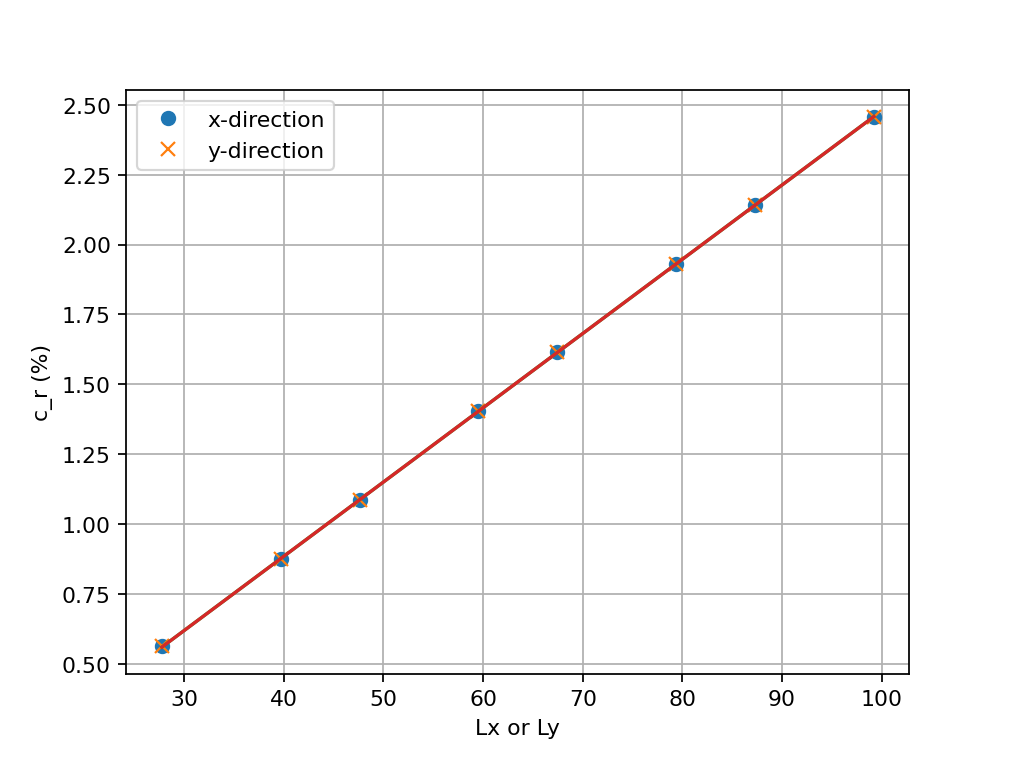

For alphasigma, D, nu_kin_ml =  0.374 151.15192925969708 0.113
px = [ 0.02657832 -0.17866028]
py = [ 0.02657832 -0.17866028]


In [23]:
# Plotting from far afield up to the box
vertical_limits = [0,alphasigma*1.1]
iextend = 6

ixbox_pre = slice(0,ixboxmin)
ixbox_post = slice(ixboxmax,nx)
plt.figure()
plt.plot(x[ixbox_pre], un[ixbox_pre,nymid], 'blue')
plt.plot(x[ixbox_post],un[ixbox_post,nymid],'blue')
plt.xlabel('x')
plt.ylim(vertical_limits)
plt.grid(True)
plt.title('Lx = ',)

iybox_pre = slice(0,iyboxmin)
iybox_post = slice(iyboxmax,ny)
plt.figure()
plt.plot(y[iybox_pre], un[nxmid,iybox_pre], 'green')
plt.plot(y[iybox_post],un[nxmid,iybox_post],'green')
plt.xlabel('y')
plt.ylim(vertical_limits)
plt.grid(True)

# This is right above the surface in the x-direction
plt.figure()
xshifted = x[ixbox]-x[nxmid]+dx/2
plt.plot(xshifted,uslicex*100,'o',label='Supersat above crystal')
p = np.polyfit(xshifted,uslicex,2); #print(p)
xshifted_theory = np.linspace(min(xshifted),max(xshifted))
plt.plot(xshifted_theory,np.polyval(p,xshifted_theory)*100,':',label='Parabolic fit')
bigixbox = [ix for ix in range(nxmid-boxradx-iextend,nxmid+boxradx+iextend)]
biguslice = un[bigixbox,nymid+boxrady]
bigxshifted = x[bigixbox]-x[nxmid]+dx/2
plt.plot(bigxshifted,biguslice*100,'x',lw=2,label='Supersat away from crystal')
plt.xlabel(r'$x (\mu m)$', fontsize=20)
plt.ylabel('supersaturation (%)',fontsize=20)
plt.grid(True)

# This is right above the surface in the y-direction
plt.figure()
yshifted = y[iybox]-y[nymid]+dy/2
plt.plot(yshifted,uslicey*100,'o',label='Supersat above crystal')
p = np.polyfit(yshifted,uslicey,2); #print(p)
yshifted_theory = np.linspace(min(yshifted),max(yshifted))
plt.plot(yshifted_theory,np.polyval(p,yshifted_theory)*100,':',label='Parabolic fit')
bigiybox = [iy for iy in range(nymid-boxrady-iextend,nymid+boxrady+iextend)]
biguslice = un[nxmid+boxradx,bigiybox]
bigyshifted = y[bigiybox]-y[nymid]+dy/2
plt.plot(bigyshifted,biguslice*100,'x',lw=2, label='Supersat away crystal')
plt.xlabel('y',fontsize=20)
plt.ylabel('supersaturation (%)',fontsize=20)
plt.grid(True)
plt.legend(['Parabolic fit','Supersat away from crystal'],loc='upper center')

# Plotting the surface supersaturation at the corner of the crystal
plt.figure()
plt.plot(Lx_list,sigmamx_list)
plt.plot(Ly_list,sigmamy_list,'o')
plt.xlabel('Lx or Ly')
plt.ylabel('Supersat at corner of crystal')
plt.grid(True)

# Graph as contour plot
fig,ax = plt.subplots()
CS = ax.contour(x,y,un.T*100)
ax.set_xlabel(r'$x (\mu m)$', fontsize=20)
ax.set_ylabel(r'$y (\mu m)$', fontsize=20)
fig.colorbar(CS)

plt.figure()
plt.plot(Lx_list,c_rx_list, 'o',label='x-direction')
plt.plot(Ly_list,c_ry_list, 'x',label='y-direction')
plt.xlabel('Lx or Ly')
plt.ylabel('c_r (%)')
plt.legend()
plt.grid(True)

if len(Lx_list) > 1:
    print('For alphasigma, D, nu_kin_ml = ', alphasigma, D, nu_kin_ml)
    px = np.polyfit(Lx_list,c_rx_list,1); print('px =', px)
    py = np.polyfit(Ly_list,c_ry_list,1); print('py =', py)
    plt.plot(Lx_list,plt.polyval(px,Lx_list))
    plt.plot(Ly_list,plt.polyval(py,Ly_list))

### Doing this again to sort out the relaxation time after a perturbation

In [24]:
# un_perturbed = cp(un)
# un_perturbed[nxmid,nymid+boxrady] = .20
# un_perturbed[nxmid-1,nymid+boxrady] = .20
# uslice_perturbed = un_perturbed[ixbox,nymid+boxrady]

# # Propagate forward a bunch of times
# ntimes_after_perturbation = 400
# ukeep = []
# tkeep = []
# count = -1
# for i in range(ntimes_after_perturbation):
#     un_perturbed = propagate(un_perturbed,ixbox,iybox,gneumanneffx,gneumanneffy,Dxeff,Dyeff)
#     count+=1
#     ukeep.append(un_perturbed[nxmid,nymid+boxrady])
#     tkeep.append(dt*count)
# tkeep = np.array(tkeep)

# uslice_perturbed_relaxed = un_perturbed[ixbox,nymid+boxrady]
# plt.figure()
# plt.plot(xshifted,uslice_perturbed*100,'s')
# plt.plot(xshifted,uslice_perturbed_relaxed*100,'o')
# plt.grid(True)

# plt.figure()
# f = (ukeep-ukeep[-1])/(ukeep[0]-ukeep[-1])
# plt.plot(tkeep,f)
# plt.xlabel('time (microseconds)')
# plt.grid(True)
# tau = tkeep[np.argmin(np.abs(f-.5))]
# print('Approximate half-life =',tau)